In [1]:
import numpy as np
import pandas as pd

import phik
import math

import matplotlib.pyplot as plt 
import seaborn as sns 

from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

%matplotlib inline

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [2]:
test = pd.read_csv('../data/test.csv')
test.shape

(565892, 55)

In [2]:
train = pd.read_csv('../data/train.csv')
train.shape

(15120, 56)

## 1. Conclusions from the previous EDA:

- there's two types of quantitative/numerical data: continuous and discrete (binary)
- the dataset is free of nulls and duplicates
- the features 'Elevation', 'Horizontal Distance To Fire Points' and 'Horizontal Distance To Roadways' present high cardinality, but not enough to be removed
- only 'Vertical Distance To Hydrology' has negative values
- there's two colums ('Soil Type15' and 'Soil Type7') only with 0s
- few features have correlation with the target
- the target is perfectly balanced

## 2. Outliers:

In [7]:
def number_of_outliers(df):
    
    df = df.select_dtypes(exclude = 'object')
    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    return ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

In [8]:
number_of_outliers(train).sort_values().tail(10)

Soil_Type32                         690
Soil_Type30                         725
Soil_Type38                         728
Soil_Type23                         757
Horizontal_Distance_To_Roadways     830
Soil_Type4                          843
Soil_Type3                          962
Soil_Type29                        1291
Soil_Type10                        2142
Wilderness_Area1                   3597
dtype: int64

In [13]:
print('outliers in Wilderness Area 1: ' + str(3597/len(train)) + ' %')

outliers in Wilderness_Area1: 0.23789682539682538 %


 - As the outliers reflect the amplitude of the forest, we decide to keep them, and to choose outlier robust algorithms based in decision trees. 

## 2. Drop features with constant (or almost constant) values and id

In [3]:
train.shape

(15120, 56)

In [3]:
train.sum().sort_values().head(20)

Soil_Type7       0
Soil_Type15      0
Soil_Type25      1
Soil_Type8       1
Soil_Type28      9
Soil_Type36     10
Soil_Type9      10
Soil_Type27     15
Soil_Type21     16
Soil_Type34     22
Soil_Type37     34
Soil_Type19     46
Soil_Type26     54
Soil_Type18     60
Soil_Type35    102
Soil_Type16    114
Soil_Type20    139
Soil_Type5     165
Soil_Type14    169
Soil_Type12    227
dtype: int64

In [4]:
df = train.drop(columns= ['Soil_Type7', 'Soil_Type15', 'Soil_Type25', 'Soil_Type8', 'Soil_Type28', 'Soil_Type36', 'Soil_Type9', 'Soil_Type27', 
'Soil_Type21', 'Soil_Type34', 'Soil_Type37', 'Soil_Type19','Soil_Type26', 'Soil_Type18','Id'])
df.shape

(15120, 41)

## 3. Correlations:

In [5]:
train = df

 - Pearson correlation:

In [6]:
abs(train.corrwith(train['Cover_Type'])).sort_values().tail(15)

Soil_Type24                        0.100797
Horizontal_Distance_To_Roadways    0.105662
Soil_Type35                        0.114327
Wilderness_Area3                   0.122146
Soil_Type10                        0.128972
Soil_Type12                        0.129985
Soil_Type32                        0.132312
Soil_Type23                        0.158762
Soil_Type22                        0.195993
Soil_Type40                        0.205851
Soil_Type29                        0.218564
Wilderness_Area1                   0.230117
Soil_Type39                        0.240384
Soil_Type38                        0.257810
Cover_Type                         1.000000
dtype: float64

In [7]:
abs(train.corrwith(train['Cover_Type'])).sort_values().head()

Soil_Type30    0.001393
Soil_Type6     0.006521
Aspect         0.008015
Soil_Type16    0.008793
Soil_Type11    0.010228
dtype: float64

- Phik correlation:

In [8]:
train.phik_matrix()['Cover_Type'].sort_values(ascending = False).head(25)

interval columns not set, guessing: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type20', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type35', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']


Cover_Type                            1.000000
Elevation                             0.801070
Wilderness_Area4                      0.754222
Horizontal_Distance_To_Roadways       0.494676
Soil_Type10                           0.492620
Soil_Type3                            0.483691
Wilderness_Area1                      0.483618
Soil_Type38                           0.445401
Horizontal_Distance_To_Fire_Points    0.440710
Soil_Type39                           0.419907
Wilderness_Area3                      0.361451
Soil_Type40                           0.353390
Soil_Type30                           0.326813
Soil_Type29                           0.322441
Horizontal_Distance_To_Hydrology      0.311203
Hillshade_9am                         0.303495
Hillshade_3pm                         0.292085
Aspect                                0.291317
Slope                                 0.281308
Soil_Type4                            0.279328
Soil_Type22                           0.271595
Soil_Type17  

In [9]:
train.phik_matrix()['Cover_Type'].sort_values(ascending = False).tail()

interval columns not set, guessing: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type20', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type35', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']


Soil_Type31    0.135432
Soil_Type11    0.133181
Soil_Type5     0.117353
Soil_Type20    0.097430
Soil_Type16    0.070697
Name: Cover_Type, dtype: float64

In [ ]:
# pearson
# Soil_Type22                        0.195993
# Soil_Type40                        0.205851
# Soil_Type29                        0.218564
# Wilderness_Area1                   0.230117
# Soil_Type39                        0.240384
# Soil_Type38                        0.257810

# phik
# Elevation                             0.801070
# Wilderness_Area4                      0.754222
# Horizontal_Distance_To_Roadways       0.494676
# Soil_Type10                           0.492620
# Soil_Type3                            0.483691
# Wilderness_Area1                      0.483618
# Soil_Type38                           0.445401
# Horizontal_Distance_To_Fire_Points    0.440710
# Soil_Type39                           0.419907
# Wilderness_Area3                      0.361451
# Soil_Type40                           0.353390
# Soil_Type30                           0.326813
# Soil_Type29                           0.322441
# Horizontal_Distance_To_Hydrology      0.311203
# Hillshade_9am                         0.303495
# Hillshade_3pm                         0.292085
# Aspect                                0.291317
# Slope                                 0.281308
# Soil_Type4                            0.279328
# Soil_Type22                           0.271595
# Soil_Type17                           0.255233
# Soil_Type13                           0.251266
# Soil_Type23                           0.249768
# Soil_Type12                           0.248816

 - Thanks to the Phik correlation, we see that there are high correlations with the target, which helps us for the creation of new features.

## 4. Creation of new features:

In [10]:
train['eDist_to_Hydrology'] = (train['Horizontal_Distance_To_Hydrology']**2 + train['Vertical_Distance_To_Hydrology']**2)**0.5 
train['human_presence'] = train['Horizontal_Distance_To_Roadways'] + train['Horizontal_Distance_To_Fire_Points']
train['Total_Hillshade_mean'] = (train['Hillshade_9am'] + train['Hillshade_3pm'] + train['Hillshade_Noon']) / 3
train['Horizontal_Distance_To_Roadways_Log'] = [math.log(v+1) for v in train['Horizontal_Distance_To_Roadways']]
train['Hillshade_Noon_Elevation_ratio'] = train['Hillshade_Noon']/(train['Elevation']+1)
train['Hillshade_9am_Elevation_ratio'] = train['Hillshade_9am']/(train['Elevation']+1)


In [11]:
train.phik_matrix()['Cover_Type'].sort_values(ascending = False).head(25)

interval columns not set, guessing: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type20', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type35', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type', 'eDist_to_Hydrology', 'human_presence', 'Total_Hillshade_mean', 'Horizontal_Distance_To_Roadways_Log', 'Hillshade_Noon_Elevation_ratio', 'Hillshade_9am_Elevation_ratio']


Cover_Type                             1.000000
Elevation                              0.801070
Wilderness_Area4                       0.754222
Hillshade_Noon_Elevation_ratio         0.617592
Hillshade_9am_Elevation_ratio          0.616461
human_presence                         0.527059
Horizontal_Distance_To_Roadways        0.494676
Soil_Type10                            0.492620
Soil_Type3                             0.483691
Wilderness_Area1                       0.483618
Soil_Type38                            0.445401
Horizontal_Distance_To_Fire_Points     0.440710
Horizontal_Distance_To_Roadways_Log    0.434802
Soil_Type39                            0.419907
Wilderness_Area3                       0.361451
Soil_Type40                            0.353390
Soil_Type30                            0.326813
Soil_Type29                            0.322441
Horizontal_Distance_To_Hydrology       0.311203
eDist_to_Hydrology                     0.308649
Hillshade_9am                          0

In [47]:
# train.to_csv('../data/train_newfeats.csv', index = False)

## 5. Transformations:

In [8]:
#train = pd.read_csv('../data/train_newfeats.csv')

In [9]:
#train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 59 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Elevation                            15120 non-null  int64  
 1   Aspect                               15120 non-null  int64  
 2   Slope                                15120 non-null  int64  
 3   Horizontal_Distance_To_Hydrology     15120 non-null  int64  
 4   Vertical_Distance_To_Hydrology       15120 non-null  int64  
 5   Horizontal_Distance_To_Roadways      15120 non-null  int64  
 6   Hillshade_9am                        15120 non-null  int64  
 7   Hillshade_Noon                       15120 non-null  int64  
 8   Hillshade_3pm                        15120 non-null  int64  
 9   Horizontal_Distance_To_Fire_Points   15120 non-null  int64  
 10  Wilderness_Area1                     15120 non-null  int64  
 11  Wilderness_Area2            

- subset with the continuous features:

In [14]:
train.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17',
       'Soil_Type20', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type35', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40', 'Cover_Type', 'eDist_to_Hydrology', 'human_presence',
       'Total_Hillshade_mean', 'Horizontal_Distance_To_Roadways_Log',
       'Hillshade_Noon_Elevation_ratio', 'Hillshade_9am_Elevation_ratio'],
      dtype='object')

In [19]:
cont_1 = train.iloc[:, 41:]
cont_2 = train.iloc[:, :10]

frames = [cont_1, cont_2]

cont = pd.concat(frames, axis= 1)


 - chech the distributions

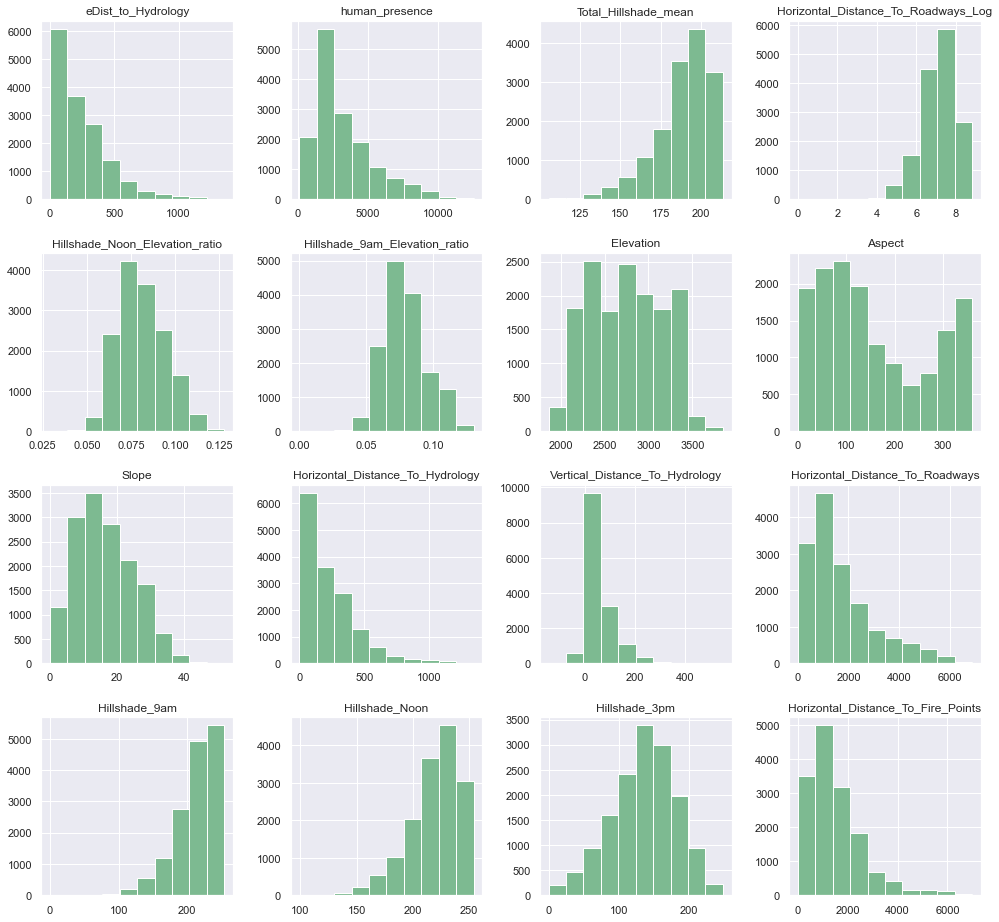

In [20]:
sns.set_theme(rc = {'figure.figsize':(15,15)}, palette='crest')

cont.hist(figsize=(15,15));

In [21]:
# skewness along the index axis
# Para comprobar la asimetría de una variable siempre podemos calcular su valor skew
# 0 si es simetrica, >0 cola hacia la derecha, <0 cola hacia la izquierda
cont.skew(axis = 0, skipna = True).sort_values(ascending = False)

Horizontal_Distance_To_Fire_Points     1.617099
Vertical_Distance_To_Hydrology         1.537776
Horizontal_Distance_To_Hydrology       1.488052
eDist_to_Hydrology                     1.442072
human_presence                         1.301516
Horizontal_Distance_To_Roadways        1.247811
Slope                                  0.523658
Aspect                                 0.450935
Hillshade_9am_Elevation_ratio          0.364249
Hillshade_Noon_Elevation_ratio         0.329628
Elevation                              0.075640
Hillshade_3pm                         -0.340827
Horizontal_Distance_To_Roadways_Log   -0.689219
Hillshade_Noon                        -0.953232
Total_Hillshade_mean                  -1.090351
Hillshade_9am                         -1.093681
dtype: float64

 - normalizing the skewness:

In [22]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

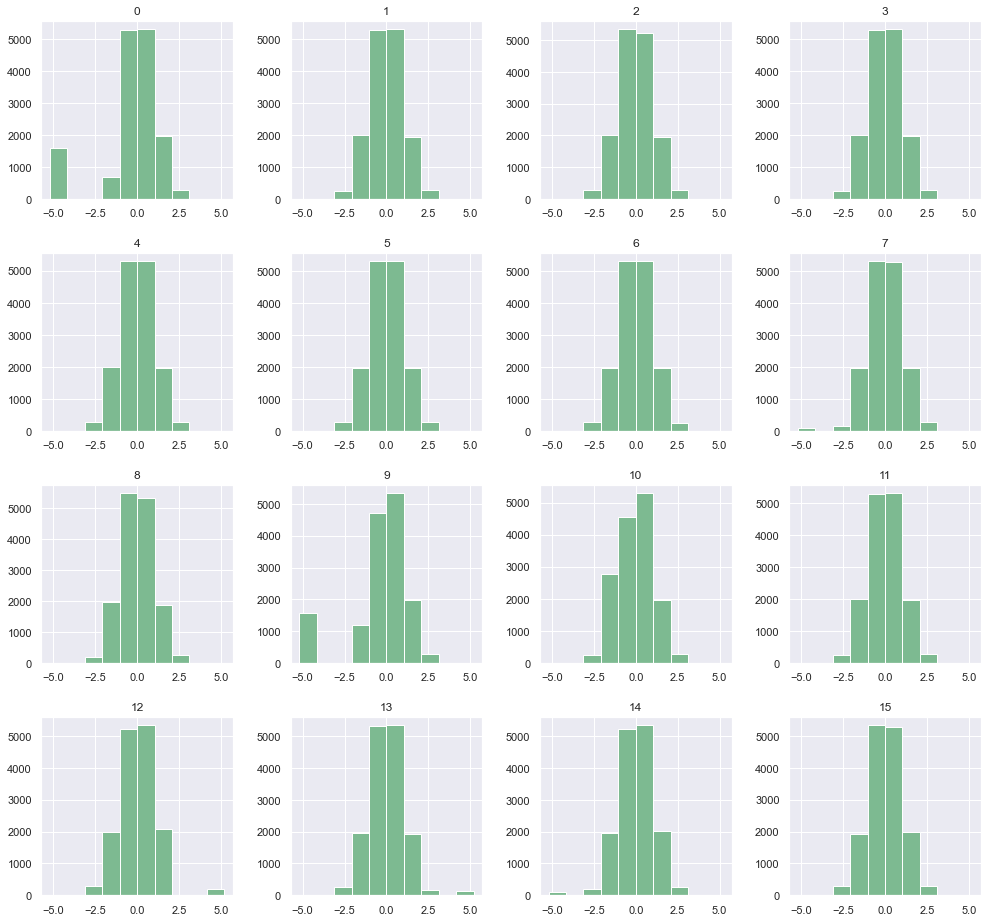

In [23]:
# perform a normal quantile transform of the cont df

trans = QuantileTransformer(n_quantiles=100, output_distribution='normal')
data = trans.fit_transform(cont)
# convert the array back to a dataframe
cont_trans = pd.DataFrame(data)
# histograms of the variables

# sns.set_theme(rc = {'figure.figsize':(15,15)}, palette='crest')
cont_trans.hist(figsize=(15,15));

#### Comparing skewness before and after the transformation:

In [24]:
data_tuples = list(zip(cont.skew(axis = 0, skipna = True),cont_trans.skew(axis = 0, skipna = True)))
comp_skew = pd.DataFrame(data_tuples, columns=['original','transformed'])
comp_skew

,original,transformed
0,1.442072,-1.685962
1,1.301516,0.004554
2,-1.090351,0.035114
3,-0.689219,-0.008694
4,0.329628,0.008146
5,0.364249,0.006744
6,0.075640,0.025288
7,0.450935,-0.662534
8,0.523658,-0.045447
9,1.488052,-1.693894


#### Transforming the whote dataset:

In [26]:
trans = QuantileTransformer(n_quantiles=100, output_distribution='normal')
data = trans.fit_transform(train)
# convert the array back to a dataframe
trans_train = pd.DataFrame(data)

In [27]:
trans_train.columns

RangeIndex(start=0, stop=47, step=1)

In [28]:
train.shape

(15120, 47)

In [29]:
train.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17',
       'Soil_Type20', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type35', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40', 'Cover_Type', 'eDist_to_Hydrology', 'human_presence',
       'Total_Hillshade_mean', 'Horizontal_Distance_To_Roadways_Log',
       'Hillshade_Noon_Elevation_ratio', 'Hillshade_9am_Elevation_ratio'],
      dtype='object')

In [30]:
# renaming the columns of the transformed dataset

trans_train.columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17',
       'Soil_Type20', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type35', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40', 'Cover_Type', 'eDist_to_Hydrology', 'human_presence',
       'Total_Hillshade_mean', 'Horizontal_Distance_To_Roadways_Log',
       'Hillshade_Noon_Elevation_ratio', 'Hillshade_9am_Elevation_ratio']


# 6. Feature selection:

#### PCAs

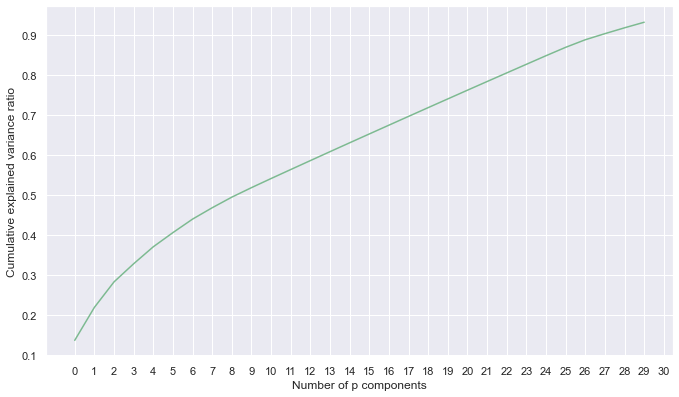

In [31]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(trans_train)

pca = PCA(n_components=30)
X_pca = pca.fit_transform(train_scaled)

plt.figure(figsize = (10,6))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of p components")
plt.ylabel("Cumulative explained variance ratio")
plt.xticks(np.arange(0,31));

#### Feature Importances

In [32]:
trans_train['Cover_Type'] = train['Cover_Type']

In [33]:
X= trans_train.drop(['Cover_Type'], axis=1) 
y= trans_train['Cover_Type']
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2)


# scaler for SVM and KNN

scaler = MinMaxScaler()
scaler.fit(X_train) 

X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)

In [34]:
# initialize the classificators
rfc= RandomForestClassifier(random_state=77)
gbc= GradientBoostingClassifier(random_state=77)
ada = AdaBoostClassifier(random_state=77)
etc = ExtraTreesClassifier(random_state=77)
lgbm = lgb.LGBMClassifier(random_state=77)
knn = KNeighborsClassifier()
lSVC = LinearSVC()


# now, create a list with the objects 
models= [rfc, gbc, ada, etc, lgbm]
models_2 = [knn, lSVC]

In [35]:
for model in models:
    model.fit(X_train, y_train) 
    train_score= model.score(X_train, y_train) 
    test_score= model.score(X_test, y_test)
    #clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The score in train of model {type(model).__name__} is {train_score:.2f}")
    print(f"The score in test of model {type(model).__name__} is {test_score:.2f}")
    #print(clf_report)
    print("\n")

The score in train of model RandomForestClassifier is 1.00
The score in test of model RandomForestClassifier is 0.86


The score in train of model GradientBoostingClassifier is 0.86
The score in test of model GradientBoostingClassifier is 0.80


The score in train of model AdaBoostClassifier is 0.30
The score in test of model AdaBoostClassifier is 0.27


The score in train of model ExtraTreesClassifier is 1.00
The score in test of model ExtraTreesClassifier is 0.86


The score in train of model LGBMClassifier is 0.99
The score in test of model LGBMClassifier is 0.85




In [36]:
for model in models_2:
    model.fit(X_train_scal, y_train)
    train_score= model.score(X_train_scal, y_train) 
    test_score= model.score(X_test_scal, y_test)
    #clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The score in train of model {type(model).__name__} is {train_score:.2f}")
    print(f"The score in test of model {type(model).__name__} is {test_score:.2f}")
    #print(clf_report)
    print("\n")

The score in train of model KNeighborsClassifier is 0.87
The score in test of model KNeighborsClassifier is 0.79


The score in train of model LinearSVC is 0.68
The score in test of model LinearSVC is 0.67




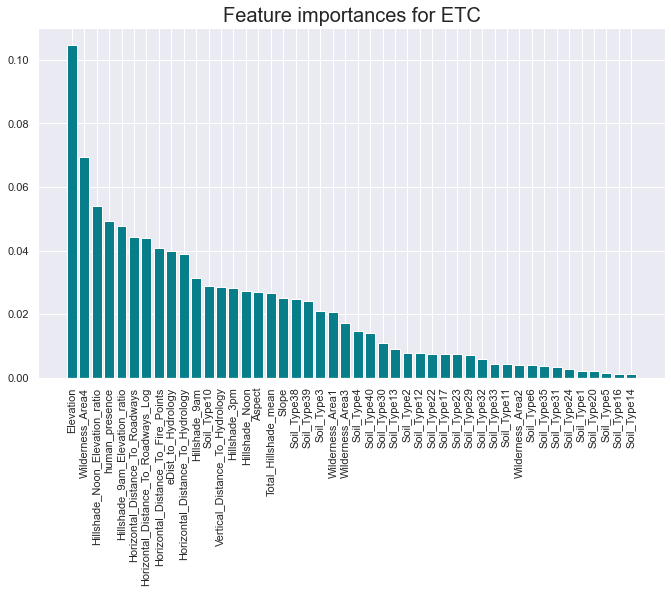

In [37]:
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': etc.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize = (10,6))

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances for ETC', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [38]:
etc_importances = importances


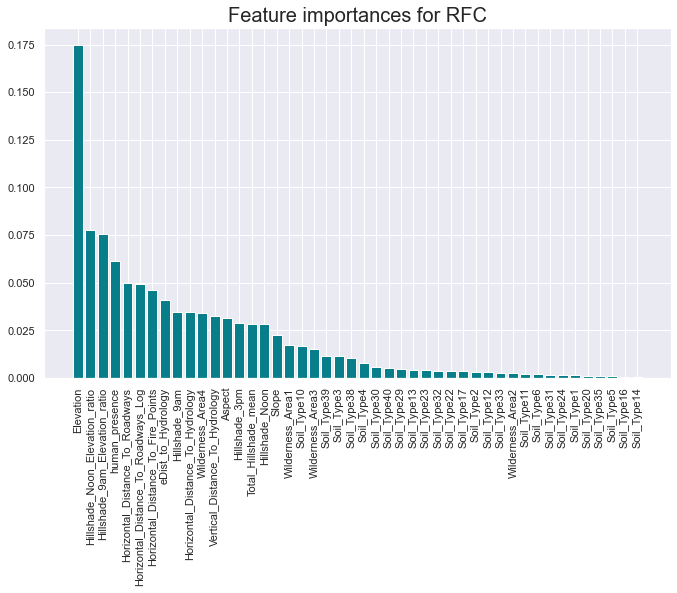

In [39]:
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': rfc.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize = (10,6))

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances for RFC', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [40]:
rfc_importances = importances

#### Selekt K best

In [42]:
from sklearn.feature_selection import SelectKBest

print(X.shape)
sel = SelectKBest(k=5)
X_new = sel.fit_transform(X, y)
names = X.columns

print(X_new.shape)

best_feats = pd.DataFrame({'column': names, 'score': sel.scores_}).sort_values('score', ascending=False)
best_feats

(15120, 46)
(15120, 5)


,column,score
0,Elevation,10145.162072
13,Wilderness_Area4,5072.497908
44,Hillshade_Noon_Elevation_ratio,3129.271591
45,Hillshade_9am_Elevation_ratio,2259.972737
41,human_presence,1605.027644
43,Horizontal_Distance_To_Roadways_Log,1097.160226
5,Horizontal_Distance_To_Roadways,1093.163581
20,Soil_Type10,977.737621
16,Soil_Type3,929.217593
10,Wilderness_Area1,928.831132


In [43]:
print(etc_importances.sort_values(by = 'Importance', ascending = False).tail())

      Attribute  Importance
14   Soil_Type1    0.002324
27  Soil_Type20    0.002026
18   Soil_Type5    0.001601
25  Soil_Type16    0.001375
24  Soil_Type14    0.001175


In [44]:
print(rfc_importances.sort_values(by = 'Importance', ascending = False).tail())

      Attribute  Importance
27  Soil_Type20    0.001081
36  Soil_Type35    0.000824
18   Soil_Type5    0.000763
25  Soil_Type16    0.000617
24  Soil_Type14    0.000275


In [45]:
print(best_feats.sort_values(by = 'score', ascending = False).tail())

         column      score
21  Soil_Type11  53.249257
18   Soil_Type5  41.381357
27  Soil_Type20  28.695745
25  Soil_Type16  15.508116
1        Aspect  15.126727


In [ ]:
# Soil_Type31    0.135432
# Soil_Type11    0.133181
# Soil_Type5     0.117353
# Soil_Type20    0.097430
# Soil_Type16    0.070697

## Conclusions:

 - the PCAs reveals that we need most of the features in order to achieve a good model
 - the best features for ETC show that certain types of soles are irrelevant for the predictions (5, 14, 16, 20)
 - the SelectKBest tool includes also the variable 'Aspect' and two more types of soils (11)
 - the Phik correlation includes all this types of soil (5, 11, 16, 20, 31)
 - so, we will drop the less significant features

We can see that the less relevant soil types only have few values, so let's drop it:

We test the data again:

In [46]:
X= trans_train.drop(['Cover_Type', 'Soil_Type5', 'Soil_Type11', 'Soil_Type16', 'Soil_Type20'], axis=1) 
y= trans_train['Cover_Type']
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2)

In [47]:
for model in models:
    model.fit(X_train, y_train) 
    train_score= model.score(X_train, y_train) 
    test_score= model.score(X_test, y_test)
    #clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The score in train of model {type(model).__name__} is {train_score:.2f}")
    print(f"The score in test of model {type(model).__name__} is {test_score:.2f}")
    #print(clf_report)
    print("\n")

The score in train of model RandomForestClassifier is 1.00
The score in test of model RandomForestClassifier is 0.86


The score in train of model GradientBoostingClassifier is 0.85
The score in test of model GradientBoostingClassifier is 0.80


The score in train of model AdaBoostClassifier is 0.36
The score in test of model AdaBoostClassifier is 0.35


The score in train of model ExtraTreesClassifier is 1.00
The score in test of model ExtraTreesClassifier is 0.87


The score in train of model LGBMClassifier is 0.99
The score in test of model LGBMClassifier is 0.86




As we can see, the score for some ensembles is better now. Let's save the data and open a new notebook to perform the model selection.

In [48]:
# save the data without transforming

# df= train.drop(['Soil_Type5', 'Soil_Type11', 'Soil_Type16', 'Soil_Type20'], axis=1) 

# df.to_csv('../data/train_newfeats_drop_3_copia.csv', index = False)

In [ ]:
'Soil_Type5', 'Soil_Type11', 'Soil_Type16', 'Soil_Type20'